In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
import torch
from torch import nn
import torch.nn.functional as tf


In [4]:
import helper

In [5]:
from torchvision import datasets, transforms


In [6]:
#Defining a tranform to normalize the data 
#Normalization is done so that range of pixel values in one image is same with the range of other images.
#It is done by subtracting the mean value (average of all the pixel values) from the pixel value and dividing result
#by the standard deviation of all the pixel values. 
#Normalization helps get data within a range and reduces the skewness which helps learn faster and better.




#his will normalize the image in the range [-1,1]. 
#For example, the minimum value 0 will be converted to (0-0.5)/0.5=-1, the maximum value of 1 will be converted to (1-0.5)/0.5=1.

#if you would like to get your image back in [0,1] range, you could use,
#image = ((image * std) + mean)

#if you look at their MNIST examples, the mean and stddev are 1-dimensional 
#(since the inputs are greyscale-- no RGB channels).


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,),)])


#Color images have three channels (red, green, blue), therefore you need three parameters to normalize each channel. 
#The first tuple (0.5, 0.5, 0.5) is the mean for all three channels and the second (0.5, 0.5, 0.5) 
#is the standard deviation for all three channels.



In [7]:
#Download and load the training data
trainset= datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download= True, train= True, transform= transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle= True)

#Download and load the testing data
testset= datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download= True, train= False, transform= transform)
testloader= torch.utils.data.DataLoader(testset, batch_size= 64, shuffle= True)





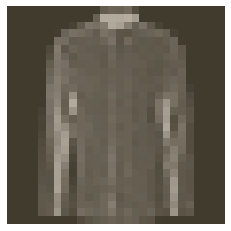

In [8]:
image, label = next(iter(trainloader))

helper.imshow(image[0,:]);

In [9]:
#Building the Network
from torch import optim
#Defining the Network Architecture
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # three linear transformations done(hidden layer)
        self.fc1=nn.Linear(784,256) 
        self.fc2 = nn.Linear(256,128)
        self.fc3=nn.Linear(128,64)
        #output layer
        self.fc4= nn.Linear(64,10)
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2) #  it means 20% of the node is not being used
    def forward(self,x):
        #Here, x is assumed to be a gray scale image
        #make sure the input tensor is flattened
        #view(rows,columns) here the output will be a vector of 28*28 values. -1 will 
        #automatically fit all of the x values into the provided column's shape
        x= x.view(x.shape[0],-1)#x.shape[0] gives batch size and -1 will fill out with as many elements as possible
        #to keep the same total number of the elements
        # Now with dropout
        x = self.dropout(tf.relu(self.fc1(x)))
        x = self.dropout(tf.relu(self.fc2(x)))
        x = self.dropout(tf.relu(self.fc3(x)))
        
        #to make the output layer a bit interpretable, we apply a softmax function to this output layer to convert
        # these scores into probabilities.
        #to apply softmax fuction to output layer, we begin by evaluating the exponential function at each score
        #then we add all the values and, then divide each of these values by total. Now, each va;ue yields the prob.
        #that the image depicts it's corresponding image class.
        x= tf.log_softmax(self.fc4(x), dim=1)
        
        return x
    
        

In [60]:
#Creating the network, defining the criterion and optimizer
model = Classifier()


criterion = nn.NLLLoss() #Defining the loss function which takes the probability and  performs negative log of value
optimizer = optim.Adam(model.parameters(), lr=0.003)

#Adam is basically same as SGD but it provides good features such as momentum, which is used to speed up the fitting
#process. it also adjusts the learning rate for each of the individual parameters in our model



In [63]:
initial_epoch = 0

In [67]:
checkpoint = torch.load('model_checkpoint.pth')
model = Classifier()
model.load_state_dict(checkpoint['state_dict'])
initial_epoch = checkpoint['epoch_no']

In [68]:
#Training the Network
epochs = 30
steps= 0
train_losses, test_losses = [],[]
for e in range(initial_epoch, epochs):
    running_loss = 0
    for images, labels in trainloader:
        #As the network trains, we measure any mistakes that it makes using the loss function, whose job is to measure
        #the difference between true and predicted class labels.
        log_ps = model(images) # calcluating the predicted labels
        loss = criterion(log_ps, labels) # loss function to measure the difference btwn  predicted and true labels
        optimizer.zero_grad()
        #Using backpropagation, we can compute the gradient of the loss w.r.t to the weights.
        #Doing this, we can quantify(generalize or get idea) how bad a particular weight is and find out the other
        #weights in the network that are responsible for any errors.
        loss.backward()
        #Finally, using the calculation, we can choose the activation function like gradient descent to give us a 
        #way to calculate a better weight values.
        optimizer.step()
        running_loss = running_loss + loss.item()
    else:
        test_loss = 0
        accuracy= 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images,labels in testloader:
                log_ps= model(images)
                test_loss+=criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        
        if e % 5 == 0:
            checkpoint = {'state_dict': model.state_dict(), 
                          'epoch_no': e}

            torch.save(checkpoint, 'model_checkpoint.pth')

            
        #print("Training loss",{running_loss/len(trainloader)})
        


Epoch: 6/30..  Training Loss: 2.308..  Test Loss: 2.308..  Test Accuracy: 0.046
Epoch: 7/30..  Training Loss: 2.308..  Test Loss: 2.308..  Test Accuracy: 0.046
Epoch: 8/30..  Training Loss: 2.308..  Test Loss: 2.308..  Test Accuracy: 0.046
Epoch: 9/30..  Training Loss: 2.308..  Test Loss: 2.308..  Test Accuracy: 0.046
Epoch: 10/30..  Training Loss: 2.308..  Test Loss: 2.308..  Test Accuracy: 0.046
Epoch: 11/30..  Training Loss: 2.308..  Test Loss: 2.308..  Test Accuracy: 0.046
Epoch: 12/30..  Training Loss: 2.308..  Test Loss: 2.308..  Test Accuracy: 0.047
Epoch: 13/30..  Training Loss: 2.308..  Test Loss: 2.308..  Test Accuracy: 0.046
Epoch: 14/30..  Training Loss: 2.308..  Test Loss: 2.308..  Test Accuracy: 0.046
Epoch: 15/30..  Training Loss: 2.308..  Test Loss: 2.308..  Test Accuracy: 0.046
Epoch: 16/30..  Training Loss: 2.308..  Test Loss: 2.308..  Test Accuracy: 0.046
Epoch: 17/30..  Training Loss: 2.308..  Test Loss: 2.308..  Test Accuracy: 0.046
Epoch: 18/30..  Training Loss: 2

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper

# Test out your network!

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[1]

# TODO: Calculate the class probabilities (softmax) for img
ps = torch.exp(model(img))

# Plot the image and probabilities
helper.view_classify(img, ps, version='Fashion')



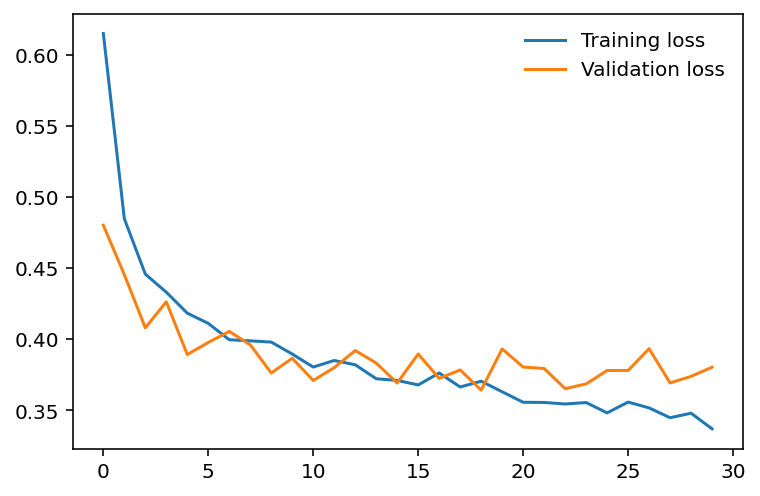

In [17]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)



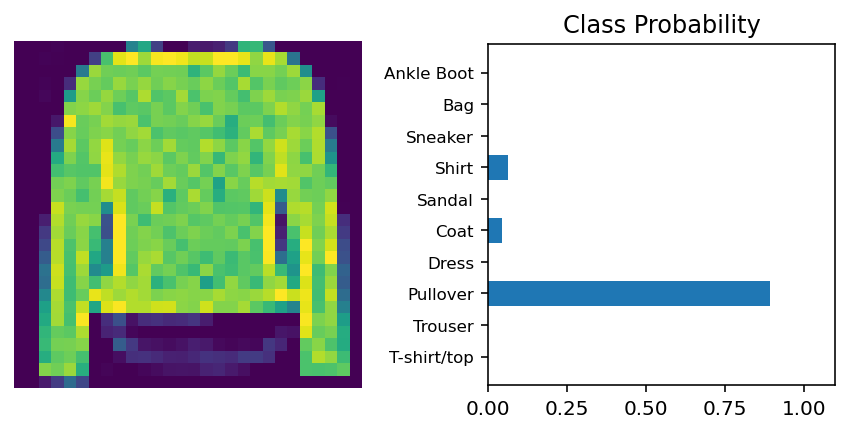

In [18]:
#Inference
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')
